## Training

This notebook is used to perform training on the synthetic dataset created to resemble the field dataset (geology and seismic acquisition)

In [3]:
import torch
from torch import nn
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler
from torch_utils import *
from torchvision import models

from utils import *
%config InlineBackend.figure_formats = ['svg']

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Loading data

Select paths where pre-computed data and labels (dispersion curves) are stored. This dataset can be generated from the respective notebook.

In [5]:
training_data_path = '../data/training/data_su/'
training_label_path = '../data/training/label/'

Load wavelet estimated from the data where the inference is intended. For this case we provide the field wavelet obtained from the field data.

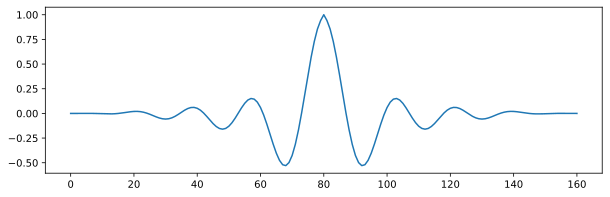

In [6]:
wavfilt_esttap = np.load('../data/wavelet.npy')
linevnts = np.load('../data/linevents.npy')
linevnts = linevnts[:, :799]

t0=0.23

plt.figure(figsize=(10,3))
plt.plot(wavfilt_esttap)

Load synthetic data to perform training on and apply pre-processing. This involves:
- adding colored noise;
- convolving the data with the wavelet estimated from the field data
- adjusting the time axis such that it starts from 0
- checking that all the shotgathers have an associated dispersion curve

Finally all traces of each shot gather are normalized with respect to their maximum value.

In [7]:
set_seed(40)
idx = [-1, -2]
training_data = []
training_data_raw = []
training_label = []
totalfiles = 1000

for m in range(1000):
    try:
        filename = str(m) + '_rvz.su'
        traces = readsu(training_data_path, filename, wholepath=True)

        training_data_raw.append(np.vstack([traces[l].data for l in range(len(traces))]))

        for tt in range(len(traces)):
            traces[tt].data = cn(traces[tt].data, 3)
            traces[tt].data = np.convolve(
                traces[tt].data, wavfilt_esttap, mode='same')
            traces[tt] = traces[tt].trim(
                traces[tt].stats.starttime+t0, traces[tt].stats.starttime+t0+0.4)

        u = traces[0:len(traces)]
        unp = np.zeros((len(u), u[0].stats.npts), dtype='float32')

        for uu in range(len(u)):
            unp[uu] = u[uu].data

        training_data.append(np.delete(unp, idx, 1))
        training_label.append(np.load(training_label_path + str(m) + '_label.npy'))
    
    except FileNotFoundError:
        print(m)
        totalfiles = totalfiles -1


In [8]:
# Normalize
training_data_noise_norm = []

for i in range(len(training_data)):
    data_noise_norm = training_data[i] / \
        training_data[i].max(axis=1)[:, np.newaxis]
    training_data_noise_norm.append(data_noise_norm)

In [9]:
# Linear event are added randomly (to 35% of the dataset)
indxs = random.sample(range(totalfiles), int(totalfiles*0.35))

for i in indxs:
    training_data_noise_norm[i] = training_data_noise_norm[i]+linevnts

We can compare the results of our preprocessing by running:

(-0.5, 24.5, 798.5, -0.5)

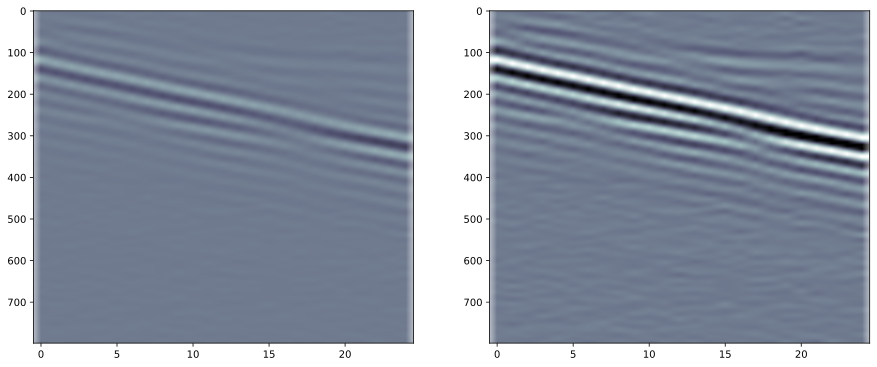

In [12]:
clip = 1e0
ran = np.random.randint(totalfiles)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].imshow(training_data[ran].T, cmap='bone', vmin=-
              5e-6*clip, vmax=5e-6*clip, interpolation='none')
axs[0].axis('tight')
axs[1].imshow(training_data_noise_norm[ran].T, cmap='bone',
              vmin=-clip, vmax=clip, interpolation='none')
axs[1].axis('tight')

Remove training samples where the label computed via the disba modelling code does not contain all expected frequency values

In [14]:
idx = []

for n in range(totalfiles):
    if training_label[n].shape[0] != 500:  # Change to 1000 if using first and fundamental mode 
        idx.append(n)

training_data = np.delete(training_data_noise_norm, idx, 0)
training_label = [training_label[l] for l in range(0, len(training_label), 1) if l not in idx]

## Training

Let's first of all prepare our data to a format that is compatible with torch

In [15]:
training_data_tensor = torch.Tensor(training_data)
training_label_tensor = torch.Tensor(training_label)

# Reshape  and add channel dimension
training_data_tensor = training_data_tensor.reshape(training_data_tensor.shape[0], 1, 
                                                    training_data_tensor.shape[1], 
                                                    training_data_tensor.shape[2])

# Building dataset
training_dataset = data.TensorDataset(training_data_tensor, training_label_tensor)

In [16]:
# Percentage of training set to use as validation
valid_size = 0.2

# Obtain training indices that will be used for validation
indices = list(range(len(training_data)))
np.random.shuffle(indices)
split = int(np.floor(valid_size * len(training_data)))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [17]:
# Define dataloaders
bs = 16 # batch size

training_loader = data.DataLoader(dataset=training_dataset, batch_size=bs, sampler=train_sampler, num_workers=0)
validating_loader = data.DataLoader(dataset=training_dataset, batch_size=bs, sampler=valid_sampler, num_workers=0)

Check dimensions

In [18]:
shot_gathers, labels = next(iter(validating_loader))
shot_gathers.shape, labels.shape

(torch.Size([16, 1, 25, 799]), torch.Size([16, 500]))

Create network

In [19]:
resnet18 = models.resnet18(pretrained=False)

In [20]:
def append_dropout(model, rate=0.2):
    """
    Adds dropout to every layer in the network
    :param model: Model to add dropout to
    :param rate: Dropout parameter
    :return: Modified model with dropout
    """
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            append_dropout(module)
        if isinstance(module, nn.ReLU):
            new = nn.Sequential(nn.Dropout2d(p=rate, inplace=True), module)
            setattr(model, name, new)

append_dropout(resnet18)  # Enhances smoothness in the predictions, can be switched off if desired

In [21]:
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

fc_inputs = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(fc_inputs, 1000)
)
print(resnet18)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): Sequential(
    (0): Dropout2d(p=0.2, inplace=True)
    (1): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Sequential(
        (0): Dropout2d(p=0.2, inplace=True)
        (1): ReLU(inplace=True)
      )
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [22]:
model = resnet18.to(device)
#summary(model, (1, 25, 799))

In [23]:
learningRate = 0.001  # Adam
alpha = 0.05  # Regularize parameter
criterion = nn.HuberLoss()
criterion_add = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

Finally we can train

In [24]:
epochs = 1000
patience = 128
model_name = 'model_multimode.pt'

train_losses = []
valid_losses = []
avg_train_losses = []
avg_valid_losses = []
early_stopping = EarlyStopping(patience=patience, path=model_name, verbose=True)

for epoch in range(epochs):
    # Train loop
    model.train()
    for batch, (shot_gathers, labels) in enumerate(training_loader):
        shot_gathers = shot_gathers.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(shot_gathers)

        # To train for first mode only ------------
        # outputs_diff = torch.diff(torch.diff(outputs, dim=-1), dim=-1)
        # loss = criterion(outputs, labels) + alpha * criterion_add(outputs_diff, torch.zeros_like(outputs_diff))

        # To train for first and fundamental mode -------------
        outputs_diff_fund = torch.diff(torch.diff(outputs[:, :500], dim=-1), dim=-1)
        outputs_diff_first = torch.diff(torch.diff(outputs[:, 500:], dim=-1), dim=-1)
        loss = criterion(outputs, labels) + alpha * criterion_add(outputs_diff_fund, torch.zeros_like(outputs_diff_fund)) + alpha * criterion_add(outputs_diff_first, torch.zeros_like(outputs_diff_first))

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    # Validation loop
    model.eval()
    for shot_gathers, labels in validating_loader:
        shot_gathers = shot_gathers.to(device)
        labels = labels.to(device)
        outputs = model(shot_gathers)

        # To train for first mode only ------------
        # outputs_diff = torch.diff(torch.diff(outputs, dim=-1), dim=-1)
        # loss = criterion(outputs, labels) + alpha * criterion_add(outputs_diff, torch.zeros_like(outputs_diff))

        # To train for first and fundamental mode -------------
        outputs_diff_fund = torch.diff(torch.diff(outputs[:, :500], dim=-1), dim=-1)
        outputs_diff_first = torch.diff(torch.diff(outputs[:, 500:], dim=-1), dim=-1)
        loss = criterion(outputs, labels) + alpha * criterion_add(outputs_diff_fund, torch.zeros_like(outputs_diff_fund)) + alpha * criterion_add(outputs_diff_first, torch.zeros_like(outputs_diff_first))
        valid_losses.append(loss.item())
    
    # Create and display training metrics
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)    
    
    epoch_len = len(str(epochs))
    if epoch % 10 == 0:
        print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                         f'train_loss: {train_loss:.5f} ' +
                         f'valid_loss: {valid_loss:.5f}')
        print(print_msg)

    train_losses = []
    valid_losses = []
    
    # Check early stopping
    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
        print('Early stopping')
        break

[   0/1000] train_loss: 416.12874 valid_loss: 392.01983
Validation loss decreased (inf --> 392.019829).  Saving model ...
Validation loss decreased (392.019829 --> 345.418919).  Saving model ...
Validation loss decreased (345.418919 --> 275.646002).  Saving model ...
Validation loss decreased (275.646002 --> 206.200988).  Saving model ...
Validation loss decreased (206.200988 --> 146.339818).  Saving model ...
Validation loss decreased (146.339818 --> 109.000832).  Saving model ...
Validation loss decreased (109.000832 --> 62.897687).  Saving model ...
Validation loss decreased (62.897687 --> 55.674703).  Saving model ...
Validation loss decreased (55.674703 --> 41.538951).  Saving model ...
Validation loss decreased (41.538951 --> 36.329494).  Saving model ...
[  10/1000] train_loss: 43.85842 valid_loss: 34.35459
Validation loss decreased (36.329494 --> 34.354591).  Saving model ...
EarlyStopping counter: 1 out of 128
Validation loss decreased (34.354591 --> 34.197483).  Saving model 

Finally we display the training losses 

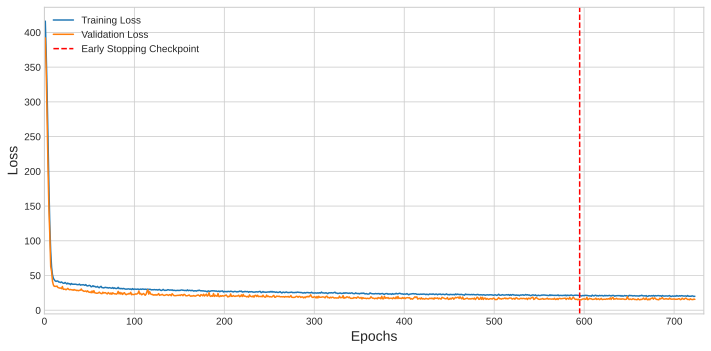

In [25]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,5))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xlim(0, len(avg_train_losses)+10) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(fname=f'{model_name[:-3]}.png',bbox_inches='tight',dpi=1200)

And perform inference for the validation data (for more detailed inference analysis use `inferencing.ipynb`)

In [39]:
outputs_list = []
labels_list = []

model.eval()
for bs, (shot_gathers, labels) in enumerate(tqdm(validating_loader)):
    shot_gathers = shot_gathers.to(device)
    outputs = model(shot_gathers)
    outputs_list.append(outputs.detach().cpu().numpy())
    labels_list.append(labels.cpu().numpy())

100%|██████████| 13/13 [00:00<00:00, 44.66it/s]


In [40]:
freq_fund = np.linspace(1/60, 1/5, 500)
freq_first = np.linspace(1/60, 1/15, 500)

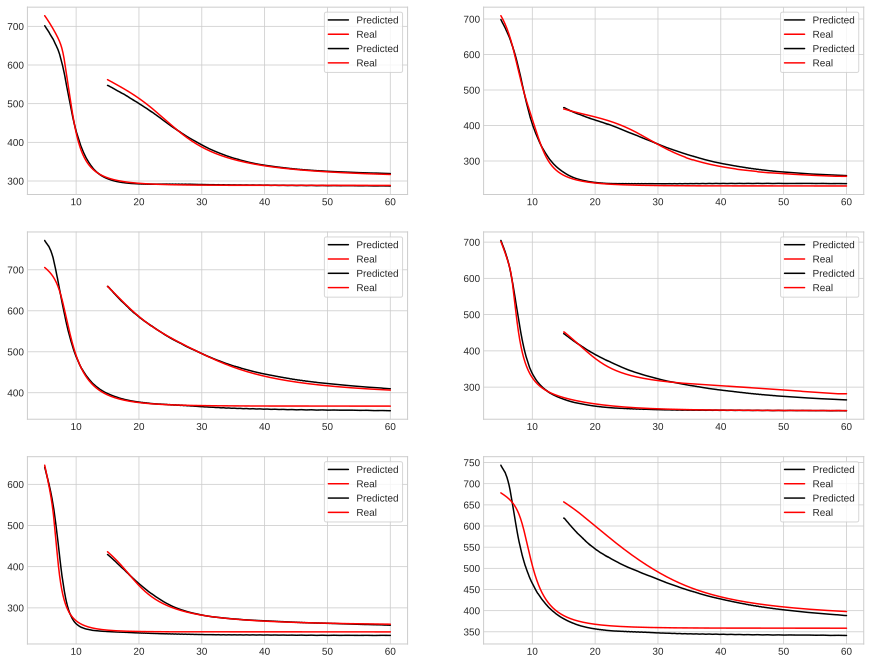

In [41]:
fig = plt.figure(figsize=(15, 20))

indxs = random.sample(range(16), 6)

for i in range(len(indxs)):
    a = fig.add_subplot(5, 2, i+1)
    plt.plot(1/freq_fund, outputs_list[0][indxs[i]][:500], 'k', label='Predicted')
    plt.plot(1/freq_fund, labels_list[0][indxs[i]][:500], 'r', label='Real')

    plt.plot(1/freq_first, outputs_list[0][indxs[i]][500:], 'k', label='Predicted')
    plt.plot(1/freq_first, labels_list[0][indxs[i]][500:], 'r', label='Real')

    plt.legend(frameon=True)

    #a.axis("off")